### 소프트맥스 회귀의 비용 함수 구현

In [1]:
import torch
import torch.nn.functional as F
import torch
import torch.nn.functional as F

In [2]:
## 로우-레벨로 구현
z = torch.FloatTensor([1, 2, 3])

In [3]:
z.shape

torch.Size([3])

In [8]:
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [9]:
hypothesis.sum()

tensor(1.)

In [10]:
z = torch.rand(3, 5, requires_grad=True)

In [12]:
hypothesis = F.softmax(z, dim=1)

In [13]:
hypothesis

tensor([[0.2376, 0.1186, 0.1976, 0.2236, 0.2226],
        [0.3142, 0.1476, 0.1459, 0.2141, 0.1781],
        [0.2853, 0.1382, 0.1447, 0.1515, 0.2802]], grad_fn=<SoftmaxBackward0>)

In [31]:
# 각 샘플에 대해 임의의 레이블 만들자.
y = torch.randint(5, (3,)).long()

In [36]:
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis)


# dim=1  y_unsqeeze(1)이 알려주는 위치에 숫자 1을 넣도록 _ 덮어쓰기 연산
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])

In [37]:
y.unsqueeze(1)

tensor([[3],
        [4],
        [0]])

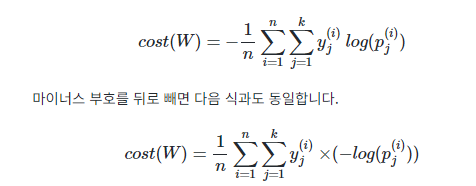

In [41]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4924, grad_fn=<MeanBackward0>)


- 하이레벨

In [43]:
# Low level
torch.log(F.softmax(z, dim=1))

In [44]:
# 2개의 함수를 결합한 F.log_softmax()라는 도구를 제공합니다.

In [45]:
# High level
F.log_softmax(z, dim=1)

tensor([[-1.4374, -2.1318, -1.6217, -1.4977, -1.5023],
        [-1.1576, -1.9132, -1.9246, -1.5411, -1.7255],
        [-1.2541, -1.9787, -1.9328, -1.8873, -1.2722]],
       grad_fn=<LogSoftmaxBackward0>)

In [46]:
# Low level
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4924, grad_fn=<MeanBackward0>)

In [48]:
(y_one_hot * -torch.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4924, grad_fn=<MeanBackward0>)

In [49]:
z

tensor([[0.7129, 0.0185, 0.5285, 0.6525, 0.6479],
        [0.8217, 0.0661, 0.0547, 0.4382, 0.2538],
        [0.8988, 0.1742, 0.2201, 0.2656, 0.8807]], requires_grad=True)

In [53]:
# Higb level
# 세번째 수식 
#  Negative Log Likelihood의 약자 -> 알아서 원핫 인코딩까지 해준다. 
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4924, grad_fn=<NllLossBackward0>)

In [56]:
# F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고 있음 (매우 중요)
# 네번째 수식
F.cross_entropy(z, y)

tensor(1.4924, grad_fn=<NllLossBackward0>)

## 소프트맥스 회귀 구현하기

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [58]:
torch.manual_seed(1)

In [59]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

#### 1) 로우-레벨

In [60]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [61]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


In [63]:
# y_train에서 원-핫 인코딩을 한 결과인 y_one_hot의 크기는 8 × 3
# 즉, W 행렬의 크기는 4 × 3

In [65]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

In [66]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    
    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)
    
    # 비용 함수
    
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.623000
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


#### 2) 하이-레벨로 구현

In [67]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    # Cost 계산
    z = x_train.matmul(W) + b
    
    cost = F.cross_entropy(z, y_train)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.623000
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375401
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


#### 3) nn.Module로 구현하기

In [68]:
#  output_dim이 1이었던 선형 회귀때와 달리 output_dim은 이제 클래스의 개수여야 함

In [69]:
# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

In [70]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.616785
Epoch  100/1000 Cost: 0.658891
Epoch  200/1000 Cost: 0.573443
Epoch  300/1000 Cost: 0.518151
Epoch  400/1000 Cost: 0.473265
Epoch  500/1000 Cost: 0.433516
Epoch  600/1000 Cost: 0.396563
Epoch  700/1000 Cost: 0.360914
Epoch  800/1000 Cost: 0.325392
Epoch  900/1000 Cost: 0.289178
Epoch 1000/1000 Cost: 0.254148


#### 4) 클래스로 구현 

In [71]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3)
        
    def forward(self, x):
        return self.linear(x)

In [72]:
model = SoftmaxClassifierModel()


In [73]:
# optimizer 설정 

optimizer = optim.SGD(model.parameters(), lr=0.1)
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    
    prediction = model(x_train)
    
    cost = F.cross_entropy(prediction, y_train)
    
    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))
    

Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428281
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250817


In [75]:
y_train.shape

torch.Size([8])

## 소프트맥스 회귀로 MNIST 데이터 분류하기

In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [4]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴

In [6]:
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용

In [7]:
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [8]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [9]:
# hyperparameters
training_epochs = 15
batch_size = 100

In [11]:
# MINIST Dataset 
mnist_train = dsets.MNIST(root='./MNIST_DATA/', 
                         train=True, 
                         transform=transforms.ToTensor(),
                         download=True)

# MINIST Dataset 
mnist_test = dsets.MNIST(root='./MNIST_DATA/', 
                         train=False, 
                         transform=transforms.ToTensor(),
                         download=True)

- drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해보자.

- 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남는다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 된다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아준다. 


In [13]:
data_loader = DataLoader(dataset=mnist_train,
                        batch_size=batch_size, 
                        shuffle=True,
                        drop_last=True)

- to() 함수는 연산을 어디서 수행할지를 정한다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보낸다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있다.

In [16]:
linear = nn.Linear(784, 10, bias=True).to(device)

- bias는 편향 b를 사용할 여부. 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True

In [17]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [21]:
for epoch in range(training_epochs):
    avg_cost  = 0 
    total_batch = len(data_loader)
    
    for X, Y in data_loader:
        X = X.view(-1, 28 * 28).to(device)
        
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')        


Epoch: 0001 cost = 0.298109710
Epoch: 0002 cost = 0.293453455
Epoch: 0003 cost = 0.289573580
Epoch: 0004 cost = 0.285963535
Epoch: 0005 cost = 0.283401549
Epoch: 0006 cost = 0.281157136
Epoch: 0007 cost = 0.278973848
Epoch: 0008 cost = 0.276851922
Epoch: 0009 cost = 0.275407284
Epoch: 0010 cost = 0.273867399
Epoch: 0011 cost = 0.272450954
Epoch: 0012 cost = 0.271237254
Epoch: 0013 cost = 0.270072371
Epoch: 0014 cost = 0.268894225
Epoch: 0015 cost = 0.267910093
Learning finished


Accuracy: 0.8806999921798706
Label:  9
Prediction:  9


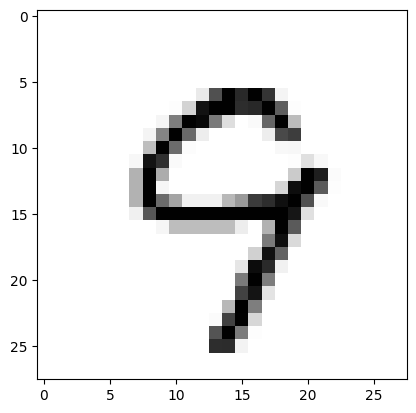

In [54]:
# 테스트 데이터를 사용하여 모델 테스트 
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    
    accuracy = correct_prediction.float().mean()
    
    print('Accuracy:', accuracy.item())
    
    
    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())
    
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

In [32]:
torch.argmax(prediction, 1)

tensor([7, 2, 1,  ..., 4, 8, 6])

In [36]:
accuracy

tensor(0.8807)